# Intro
In this analysis we have a dtaset of 10000 restaurant reviwews. We would like to understand who is often reviewing restaurants and what does affect this behaviour:
- we will study the relationship between the number of reviews that the user did, the restaurant has, and the review the user gave.
- when does a user who doesn't regularaly do reviews gives a review? 
    - positive-negative-long-short?
    - When his opinion is similar or different? 
    - When the restaurant already has too many or too less reviews?
- How honest are the people who give too many reviews?
    - can we tell this by just comparing their reviews to the avarage reviews of the restaurant?
    - do they always give positive or negative? and how do their opinions vary from the others?
- We will also use the Time of review to predict the meal
- How does the times of the year corelate with the ammount and quality of reviews
- Add sentiment analysis?!
- based on the sentiment, how do ratings relate to the evaluation of the review?

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

In [2]:
df = pd.read_csv("Restaurant reviews.csv")

# Data cleaning

In [3]:
df.head(3)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN


In [4]:
# anonymize the names
unique_users = df['Reviewer'].unique()
user_mapping = {user: f'Reviewer{idx+1}' for idx, user in enumerate(unique_users)}

df['Reviewer'] = df['Reviewer'].map(user_mapping)

In [5]:
df.Rating = pd.to_numeric(df['Rating'], errors='coerce')

In [6]:
# Are there any rows with no ratings? 
df.Rating.isna().sum()

39

In [7]:
# Drop these rows
df = df.dropna(subset='Rating')
df.Rating.isna().sum()

0

In [8]:
#check duplications
df.duplicated().sum()

0

In [9]:
df.head(2)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Reviewer1,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Reviewer2,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN


## extracting amount of followers and reviews
It seems that there are different patterns in the column Metadata. We want to extract the amount of followers and reviews and write them into two neumiric columns

In [10]:
def extract_patterns(metadata):
    patterns = set()
    for row in metadata:
        words = re.findall(r'\b[A-Za-z]+\b', row)
        patterns.add(tuple(words))
    return patterns

extract_patterns(df['Metadata'])

{('Post', 'Followers'),
 ('Posts', 'Followers'),
 ('Review',),
 ('Review', 'Follower'),
 ('Review', 'Followers'),
 ('Reviews',),
 ('Reviews', 'Follower'),
 ('Reviews', 'Followers')}

In [11]:
def extract_numbers(metadata):
    reviews = []
    followers = []
    for row in metadata:
        review_match = re.search(r'(\d+)\s*(?:Review|Reviews|Post|Posts)', row)
        reviews.append(int(review_match.group(1)) if review_match else 999999999) # 999999999 to test if the search was correct
        
        follower_match = re.search(r'(\d+)\s*(?:Follower|Followers)', row)
        followers.append(int(follower_match.group(1)) if follower_match else 0)
    
    return reviews, followers

# Extracting numbers for reviews and followers
df['Reviews'], df['Followers'] = extract_numbers(df['Metadata'])

In [12]:
df.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514,Reviews,Followers
0,Beyond Flavours,Reviewer1,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0,1,2
1,Beyond Flavours,Reviewer2,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN,3,2
2,Beyond Flavours,Reviewer3,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN,2,3
3,Beyond Flavours,Reviewer4,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN,1,1
4,Beyond Flavours,Reviewer5,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN,3,2


In [13]:
df.Reviews.isna().sum(), df.Followers.isna().sum()

(0, 0)

In [14]:
# Check if all the reviews are written correctly
df.loc[df.Reviews==999999999]

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514,Reviews,Followers


In [15]:
#now we drop the Metadata Column
df = df.drop(columns=['Metadata', '7514'])

In [16]:
# is there still any missing values? it is okay if there are 7 missing reviews
df.isnull().sum().to_frame().rename(columns={0:"Total Num of Missing Values"})

,Total Num of Missing Values
Restaurant,0
Reviewer,0
Review,7
Rating,0
Time,0
Pictures,0
Reviews,0
Followers,0


## new columns

In [17]:
len(df)

9961

In [18]:
len(df['Review'][0])

222

In [19]:
# Convert 'Review_Text' to string, replace NaNs with empty strings, and remove punctuation
df['Review'] = df['Review'].astype(str).fillna('').str.lower().str.replace('[^\w\s]', '', regex=True)

In [20]:
# Add a column for the length of each review
df['Review_Length'] = df['Review'].apply(len)

In [21]:
df['Sentiment'] = df['Review'].apply(lambda txt: sent_tokenize(txt))

In [22]:
# Add sentiment analysis
sid = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Review'].apply(lambda x: sid.polarity_scores(x)['compound'])

## seasons and meals

In [23]:
df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y %H:%M', errors='coerce')

In [24]:
def determine_meal(time):
    if 6 <= time.hour < 11:
        return 'breakfast'
    elif 11 <= time.hour < 18:
        return 'lunch'
    else:
        return 'dinner'

df['meal'] = df['Time'].apply(determine_meal)

def determine_season(date):
    year = date.year
    spring_start = pd.Timestamp(year=year, month=3, day=20)
    summer_start = pd.Timestamp(year=year, month=6, day=21)
    fall_start = pd.Timestamp(year=year, month=9, day=22)
    winter_start = pd.Timestamp(year=year, month=12, day=21)

    if spring_start <= date < summer_start:
        return f'spring'
    elif summer_start <= date < fall_start:
        return f'summer'
    elif fall_start <= date < winter_start:
        return f'fall'
    else:
        return f'winter'

df['season'] = df['Time'].apply(determine_season)
df = df.drop(columns=['Time'])

df.head(3)

,Restaurant,Reviewer,Review,Rating,Pictures,Reviews,Followers,Review_Length,Sentiment,meal,season
0,Beyond Flavours,Reviewer1,the ambience was good food was quite good had...,5.0,0,1,2,215,0.9664,lunch,spring
1,Beyond Flavours,Reviewer2,ambience is too good for a pleasant evening se...,5.0,0,3,2,139,0.9360,lunch,spring
2,Beyond Flavours,Reviewer3,a must try great food great ambience thnx for ...,5.0,0,2,3,175,0.9186,dinner,spring


# First analysis
Relationship between the number of reviews by a user and the average rating they give:

- The users with more reviews tend to give higher ratings


In [25]:
user_review_counts = df['Reviewer'].value_counts().reset_index()
user_review_counts.columns = ['Reviewer', 'Review_Count']

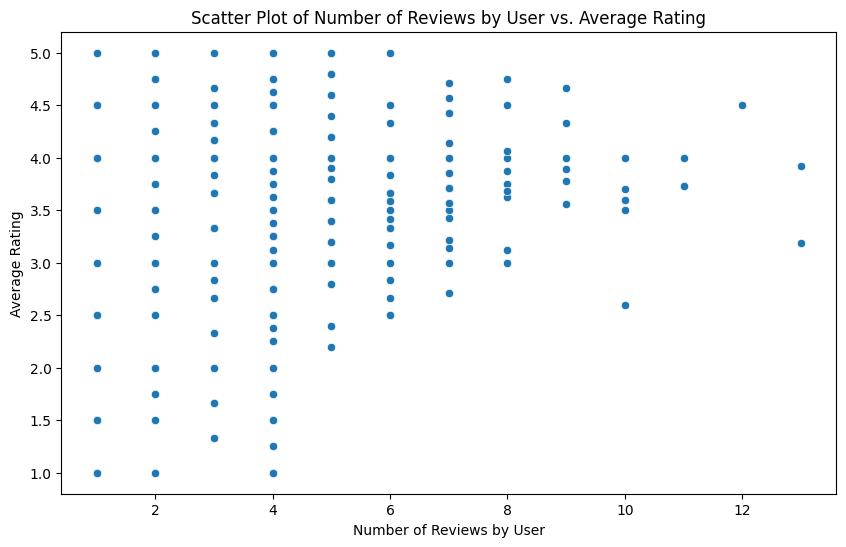

In [26]:
user_avg_rating = df.groupby('Reviewer')['Rating'].mean().reset_index()
user_avg_rating.columns = ['Reviewer', 'Avg_Rating']
user_avg_rating = user_avg_rating.merge(user_review_counts, on='Reviewer')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Review_Count', y='Avg_Rating', data=user_avg_rating)
plt.xlabel('Number of Reviews by User')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Number of Reviews by User vs. Average Rating')
plt.show()

In [27]:
data = user_avg_rating[user_avg_rating['Review_Count'].isin([1,2])]
data

,Reviewer,Avg_Rating,Review_Count
0,Reviewer1,5.0,1
1,Reviewer10,5.0,1
3,Reviewer1000,3.0,1
4,Reviewer1001,4.5,2
6,Reviewer1003,1.0,1
...,...,...,...
7441,Reviewer995,1.0,1
7442,Reviewer996,1.0,1
7443,Reviewer997,4.0,1
7444,Reviewer998,4.0,1


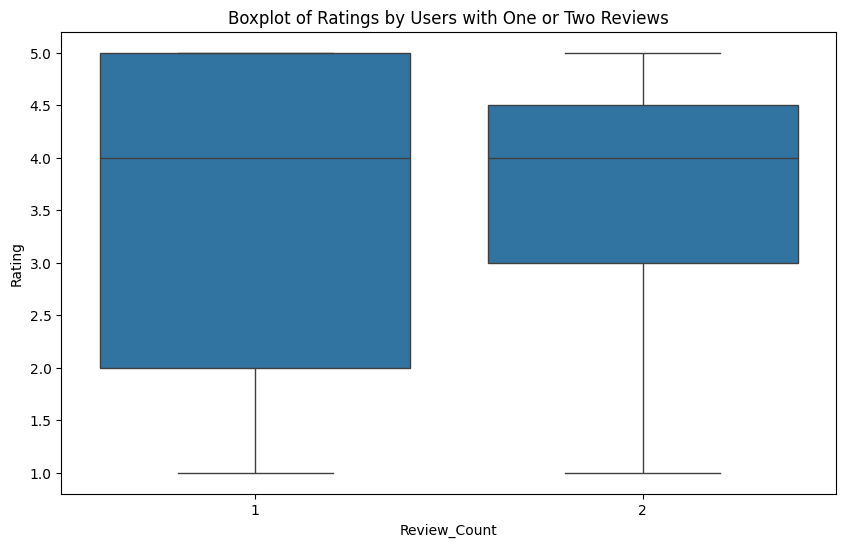

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Review_Count', y='Avg_Rating', data=user_avg_rating[user_avg_rating['Review_Count'].isin([1,2])])
plt.xlabel('Review_Count')
plt.ylabel('Rating')
plt.title('Boxplot of Ratings by Users with One or Two Reviews')
plt.show()
